In [1]:
import numpy as np

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

import pandas
import os
from pydantic import BaseModel, Field
from typing import Literal, List
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from functools import partial
from rich import print as rprint
from IPython.display import Markdown, display

try:
    _SETUP
    print("Running on folder: ", os.getcwd())
except NameError:
    _SETUP = True
    os.chdir("..")
    print("Running on folder: ", os.getcwd())


# from llm.structured import create, create_iterable, create_sequence

Running on folder:  /Users/andre/research/odsc


In [2]:
class CustomerProperties(BaseModel):
    id: str
    age: int
    n_children: int
    marital_status: Literal["Single", "Married", "Divorced", "Widow", "Widower"]
    education: Literal["Basic", "Graduation", "Master", "PhD"]
    income: float
    online_spend: float
    store_spend: float
    received_offer: bool
    aov: float

    aov_after_campaign: float
    average_discount: float
    uplift: float

In [3]:
import numpy as np
import random
import uuid


def generate_synthetic_customer() -> CustomerProperties:
    """Generate synthetic customer data following realistic distributions"""

    # Generate random but realistic values
    # Age follows a skewed normal distribution centered around 45 with most customers between 25-65
    age = int(np.random.normal(45, 12))
    age = max(18, min(90, age))  # Clip to reasonable bounds

    # Younger people are more likely to have basic education, older more likely to have advanced degrees
    if age < 25:
        weights = [0.4, 0.5, 0.09, 0.01]  # More basic/graduation for young
    elif age < 35:
        weights = [0.2, 0.6, 0.15, 0.05]  # Peak graduation age
    elif age < 50:
        weights = [0.15, 0.45, 0.3, 0.1]  # More masters/PhD for middle age
    else:
        weights = [0.25, 0.4, 0.25, 0.1]  # Mixed distribution for older

    education = random.choices(
        ["Basic", "Graduation", "Master", "PhD"], weights=weights
    )[0]

    # Younger people less likely to have children, middle-aged more likely
    if age < 25:
        weights = [0.8, 0.15, 0.04, 0.01, 0]  # Mostly no children when very young
    elif age < 35:
        weights = [0.4, 0.35, 0.2, 0.04, 0.01]  # Growing family phase
    elif age < 50:
        weights = [0.2, 0.3, 0.35, 0.1, 0.05]  # Peak family size
    else:
        weights = [0.3, 0.3, 0.25, 0.1, 0.05]  # Mixed distribution for older
    n_children = random.choices([0, 1, 2, 3, 4], weights=weights)[0]

    # Marital status probabilities vary by age
    if age < 25:
        weights = [0.8, 0.15, 0.04, 0.01, 0]  # Mostly single when young
    elif age < 35:
        weights = [0.4, 0.45, 0.12, 0.02, 0.01]  # More marriages
    elif age < 50:
        weights = [0.2, 0.55, 0.2, 0.03, 0.02]  # Peak marriage years
    else:
        weights = [0.15, 0.45, 0.25, 0.08, 0.07]  # More divorced/widowed when older

    marital_status = random.choices(
        ["Single", "Married", "Divorced", "Widow", "Widower"], weights=weights
    )[0]

    # Income follows a log-normal distribution
    # Base income parameters adjusted by age and education
    base_mean = 10.5  # Base log income (~36k)

    # Age adjustment: Income tends to increase with age until ~55, then plateaus/slightly decreases
    age_factor = min((age - 18) * 0.03, 1.1)  # Max +110% increase

    # Education adjustment
    education_boost = {
        "Basic": 0,
        "Graduation": 0.3,  # +30% boost
        "Master": 0.6,  # +60% boost
        "PhD": 0.9,  # +90% boost
    }

    adjusted_mean = base_mean + np.log(
        (1 + age_factor) * (1 + education_boost[education])
    )
    income = float(np.random.lognormal(mean=adjusted_mean, sigma=0.4))

    # After income calculation, add spending pattern generation
    total_spending_capacity = income * random.uniform(
        0.01, 0.03
    )  # 1-3% of income for this category

    # Calculate online vs store split based on characteristics
    online_bias = 0.5  # Start with 50-50 split

    # Age factor: younger -> more online
    online_bias += (50 - age) * 0.01  # +/- 0.3 max

    # Education factor: higher education -> more online
    education_online_boost = {
        "Basic": -0.1,
        "Graduation": 0,
        "Master": 0.1,
        "PhD": 0.15,
    }
    online_bias += education_online_boost[education]

    # Children factor: more children -> more store
    online_bias -= n_children * 0.05

    # Clip to reasonable bounds (20-80% split)
    online_bias = max(0.2, min(0.8, online_bias))

    # Calculate final spending with some random variation
    online_spend = float(
        total_spending_capacity * (online_bias + random.uniform(-0.1, 0.1))
    )
    store_spend = float(
        total_spending_capacity * ((1 - online_bias) + random.uniform(-0.1, 0.1))
    )

    # Randomly assign if they received an offer
    # Calculate total spend and online ratio
    total_spend = online_spend + store_spend
    online_ratio = online_spend / total_spend if total_spend > 0 else 0.5

    # Base 50% chance modified by online ratio
    # For predominantly online customers (ratio ~0.8), chance becomes ~60%
    # For predominantly store customers (ratio ~0.2), chance becomes ~40%
    offer_probability = 0.5 * (1 + (online_ratio - 0.5))
    received_offer = random.random() < offer_probability

    # Calculate AOV (Average Order Value) before and after campaign
    # Only meaningful if they received an offer
    base_aov = (online_spend + store_spend) / random.uniform(
        8, 15
    )  # Assume 8-15 orders per period

    if received_offer:
        aov_before_campaign = base_aov

        # Calculate uplift factors
        # 1. Online vs Store factor (0.0 to 0.15)
        # Store-heavy customers get more uplift
        online_ratio = (
            online_spend / (online_spend + store_spend)
            if (online_spend + store_spend) > 0
            else 0.5
        )
        channel_uplift = 0.15 * (
            1 - online_ratio
        )  # max uplift for store-only customers

        # 2. Income factor (0.0 to 0.10)
        # Lower income gets higher uplift
        # Using log income since income is log-normally distributed
        log_income = np.log(income)
        min_log_income = np.log(30000)  # Assuming minimum income of 30k
        max_log_income = np.log(200000)  # Assuming maximum income of 200k
        income_factor = (max_log_income - log_income) / (
            max_log_income - min_log_income
        )
        income_uplift = 0.10 * max(0, min(1, income_factor))  # Clamp between 0-1

        # 3. Kids factor (0.0 to 0.05 per child, max 0.15)
        kids_uplift = min(0.15, n_children * 0.05)

        # Combine all factors and add some randomness
        total_uplift = channel_uplift + income_uplift + kids_uplift
        final_uplift = total_uplift * random.uniform(
            0.8, 1.2
        )  # Add ±20% random variation

        # Apply uplift (max total uplift ~0.4 or 40%)
        aov_after_campaign = base_aov * (1 + final_uplift)

        discount_percentage = random.uniform(0.10, 0.15)  # 5-15% discount
        average_discount = float(aov_after_campaign * discount_percentage)
    else:
        # If no offer, keep values stable with small random variation
        aov_before_campaign = base_aov
        aov_after_campaign = base_aov * (1 + random.uniform(-0.05, 0.05))
        average_discount = 0.0

    return CustomerProperties(
        id=str(uuid.uuid4()),
        age=age,
        n_children=n_children,
        marital_status=marital_status,
        education=education,
        income=income,
        online_spend=online_spend,
        store_spend=store_spend,
        received_offer=received_offer,
        aov=aov_before_campaign,
        aov_after_campaign=aov_after_campaign,
        average_discount=average_discount,
        uplift=aov_after_campaign - aov_before_campaign,
    )

In [4]:
customers = [generate_synthetic_customer() for _ in range(100000)]

In [5]:
df = pandas.DataFrame([x.model_dump() for x in customers])

In [6]:
rprint(customers[0])

CustomerProperties(
    id='e26e9cf4-b3e7-484a-ae3d-d08ff3090c40',
    age=27,
    n_children=0,
    marital_status='Single',
    education='Graduation',
    income=42717.84454969833,
    online_spend=331.0995012411492,
    store_spend=127.88826501964472,
    received_offer=False,
    aov=52.77328826413375,
    aov_after_campaign=51.67981688788716,
    average_discount=0.0,
    uplift=-1.0934713762465833
)

In [7]:
df

,id,age,n_children,marital_status,education,income,online_spend,store_spend,received_offer,aov,aov_after_campaign,average_discount,uplift
0,e26e9cf4-b3e7-484a-ae3d-d08ff3090c40,27,0,Single,Graduation,42717.844550,331.099501,127.888265,False,52.773288,51.679817,0.000000,-1.093471
1,e6cf7e06-0bf9-48b3-8d79-2fce7251dd39,52,0,Married,Graduation,125070.533662,592.126431,720.578242,True,155.913864,171.618907,24.797628,15.705043
2,7c7e7f79-5b42-48fe-ae40-6139516c58ab,53,1,Divorced,PhD,74574.979272,1081.681763,843.783584,False,197.944174,194.308555,0.000000,-3.635619
3,991c1f3f-1975-45c7-8ee9-11a42103453a,38,1,Single,Basic,40039.546470,406.724644,397.551741,True,67.127119,79.917649,9.975339,12.790530
4,ed31efcd-7eb2-49b4-a9bd-c4be5c0fd151,67,0,Married,Basic,48183.962077,268.648408,806.621932,False,74.838157,73.313911,0.000000,-1.524246
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,07ade41f-04aa-436d-8ef8-3b33102cdde3,30,4,Single,Graduation,55929.657012,430.514509,398.291968,True,71.357654,92.475559,10.094659,21.117906
99996,dfd17fd9-e75a-492b-a783-465dfc656f7b,53,2,Married,Basic,126871.827519,944.085954,2007.671532,False,301.592628,298.815955,0.000000,-2.776674
99997,13789b53-82a0-4526-bdd3-6d50720a0592,62,2,Married,Basic,118482.365436,856.664416,2362.295361,False,390.671089,372.512951,0.000000,-18.158138
99998,256e01f4-5c70-4c5c-a65e-ec2131fc961c,44,1,Married,Graduation,60699.592445,317.178446,318.483433,True,75.609139,91.450637,10.278390,15.841498


In [8]:
from effects.effects import (
    EffectEstimator,
    CategoricalTreatmentParams,
    CategoricalOutcomeParams,
    ContinuousTreatmentParams,
    ContinuousOutcomeParams,
)
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


covariates = [
    "age",
    "n_children",
    "marital_status",
    "education",
    "income",
    "online_spend",
    "store_spend",
    "aov",
]

effect_estimation = EffectEstimator(
    df,
    classifier=RandomForestClassifier,
    classifier_kwargs={"max_depth": 4},
    regressor=RandomForestRegressor,
    regressor_kwargs={"max_depth": 4},
)
# print(results.explain())

/Users/andre/research/odsc/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
ite = effect_estimation.fit_predict(
    treatment=CategoricalTreatmentParams(
        column="received_offer",
        treatment_classes=["True"],
    ),
    outcome=ContinuousOutcomeParams(
        column="uplift",
    ),
    covariates=covariates,
    max_classes=5,
)

/Users/andre/research/odsc/.venv/lib/python3.12/site-packages/pygam/pygam.py:225: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if (self.terms is not 'auto') and not (isinstance(self.terms, (TermList, Term, type(None)))):
/Users/andre/research/odsc/.venv/lib/python3.12/site-packages/pygam/pygam.py:276: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if self.terms is 'auto':


TypeError: super(type, obj): obj must be an instance or subtype of type

In [19]:
data = ite.data

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor


def extract_predicted_cost(df: pandas.DataFrame) -> pandas.Series:

    model = HistGradientBoostingRegressor()
    X = df[df["received_offer"] == "True"][covariates]
    y = df[df["received_offer"] == "True"]["average_discount"]

    categorical_features = ["marital_status", "education"]
    numeric_features = [col for col in covariates if col not in categorical_features]

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", "passthrough", numeric_features),
            ("cat", OneHotEncoder(drop="first"), categorical_features),
        ]
    )

    model = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("regressor", RandomForestRegressor(max_depth=4)),
        ]
    )

    model.fit(X, y)
    return model.predict(df[covariates])

In [21]:
data["predicted_cost"] = extract_predicted_cost(data)
data["reward"] = data["effect"] - data["predicted_cost"]

In [22]:
data["reward"].mean()

4.454474523217197

In [23]:
def sampler(
    effect_estimator: EffectEstimator,
    data: pandas.DataFrame,
    vars: list[str],
    covariates: list[str],
):
    results = []
    for covariate in covariates:
        p = pandas.DataFrame()
        isCategorical = effect_estimator.data_manager.is_categorical(covariate)

        # we measure the base
        if isCategorical:
            grouper = data.groupby(covariate)
        else:
            n = 5
            good = False
            while n > 2:
                try:
                    data["quantile"] = pandas.qcut(data[covariate], n)
                    grouper = data.groupby("quantile", observed=False)
                    good = True
                    break
                except:
                    n = n - 1

            if not good:
                data["quantile"] = pandas.qcut(data[covariate], n, duplicates="drop")
                grouper = data.groupby("quantile")

            grouper = data.groupby("quantile", observed=False)

        for var in vars:
            mean_effect = grouper[var].mean()
            p[var] = mean_effect
        p["covariate"] = covariate
        results.append(p)
    return results


r = sampler(effect_estimation, data, ["reward", "predicted_cost", "effect"], covariates)

In [24]:
for elm in r:
    rprint(elm)

reward  predicted_cost     effect covariate
quantile                                                     
(17.999, 34.0] -0.535579       17.569306  17.033727       age
(34.0, 41.0]    4.226427       23.352916  27.579343       age
(41.0, 48.0]    5.974531       26.238081  32.212613       age
(48.0, 55.0]    5.790467       28.246733  34.037200       age
(55.0, 90.0]    6.976636       29.285937  36.262573       age

reward  predicted_cost     effect   covariate
quantile                                                       
(-0.001, 1.0]  -2.271075       24.239313  21.968239  n_children
(1.0, 2.0]     13.674998       25.525871  39.200869  n_children
(2.0, 4.0]     15.934010       26.151528  42.085538  n_children

reward  predicted_cost     effect       covariate
marital_status                                                     
Divorced        5.209548       26.077667  31.287215  marital_status
Married         4.679774       25.097029  29.776803  marital_status
Single          2.948804       22.552297  25.501102  marital_status
Widow           5.530858       27.182138  32.712996  marital_status
Widower         6.166009       27.183709  33.349718  marital_status

reward  predicted_cost     effect  covariate
education                                                 
Basic       6.724524       18.214925  24.939449  education
Graduation  4.827522       23.156053  27.983575  education
Master      3.146146       29.620489  32.766635  education
PhD         0.957613       35.416298  36.373911  education

reward  predicted_cost     effect covariate
quantile                                                               
(10147.896, 56065.784]    4.010641       11.747050  15.757691    income
(56065.784, 75042.713]    4.942699       17.336798  22.279497    income
(75042.713, 96057.282]    5.276382       22.442774  27.719156    income
(96057.282, 127419.529]   5.019189       28.935177  33.954367    income
(127419.529, 555464.312]  3.023462       43.735367  46.758829    income

reward  predicted_cost     effect     covariate
quantile                                                               
(39.497, 447.216]     7.926021       12.132998  20.059019  online_spend
(447.216, 669.771]    6.615289       16.952273  23.567562  online_spend
(669.771, 934.07]     5.836720       21.759326  27.596046  online_spend
(934.07, 1359.128]    3.841431       28.406335  32.247766  online_spend
(1359.128, 9702.646] -1.947088       44.946235  42.999146  online_spend

reward  predicted_cost     effect  \
quantile                                                             
(27.526999999999997, 417.111]  1.232883       11.611039  12.843921   
(417.111, 651.241]             2.144275       16.869721  19.013996   
(651.241, 927.828]             5.117035       21.943558  27.060593   
(927.828, 1370.18]             6.055977       28.707766  34.763744   
(1370.18, 8318.685]            7.722203       45.065083  52.787285   

                                 covariate  
quantile                                    
(27.526999999999997, 417.111]  store_spend  
(417.111, 651.241]             store_spend  
(651.241, 927.828]             store_spend  
(927.828, 1370.18]             store_spend  
(1370.18, 8318.685]            store_spend

reward  predicted_cost     effect covariate
quantile                                                          
(12.275, 85.024]     4.115494        9.351925  13.467419       aov
(85.024, 122.455]    6.566287       15.337550  21.903837       aov
(122.455, 167.595]   5.514377       21.230935  26.745311       aov
(167.595, 239.193]   4.637828       29.179839  33.817667       aov
(239.193, 1487.441]  1.438387       49.096918  50.535305       aov

In [27]:
class CustomerState(BaseModel):
    id: str
    age: int
    n_children: int
    marital_status: Literal["Single", "Married", "Divorced", "Widow", "Widower"]
    education: Literal["Basic", "Graduation", "Master", "PhD"]
    income: float
    online_spend: float
    store_spend: float
    aov: float
    average_discount: float


def customer_state_from_df(df: pandas.DataFrame) -> CustomerState:
    # Create initial states dataframe
    initial_states = df.copy()
    initial_states["aov"] = df["aov"]
    initial_states["average_discount"] = 0.0

    # Create final states dataframe
    final_states = df.copy()
    final_states["aov"] = df["aov_after_campaign"]
    final_states["average_discount"] = df["average_discount"]

    # Select only needed columns for CustomerState
    columns = [
        "id",
        "age",
        "n_children",
        "marital_status",
        "education",
        "income",
        "online_spend",
        "store_spend",
        "aov",
        "average_discount",
    ]

    # Convert to list of CustomerState objects
    initial_states = [
        CustomerState(**row) for row in initial_states[columns].to_dict("records")
    ]
    final_states = [
        CustomerState(**row) for row in final_states[columns].to_dict("records")
    ]

    return {"before": initial_states, "after": final_states}

In [28]:
s = customer_state_from_df(df)["before"]
rprint(s[0])

CustomerState(
    id='20da45a4-8bd4-4362-a208-f80973f6312c',
    age=27,
    n_children=2,
    marital_status='Single',
    education='Graduation',
    income=48593.71525603399,
    online_spend=604.3592768851554,
    store_spend=397.5373064812405,
    aov=77.2464861106002,
    average_discount=0.0
)

In [29]:
customer_df = pandas.DataFrame([x.model_dump() for x in s])

effect_estimation.predict(customer_df.iloc[:200])

,id,age,n_children,marital_status,education,income,online_spend,store_spend,aov,average_discount,effect,treatment,outcome
0,20da45a4-8bd4-4362-a208-f80973f6312c,27,2,Single,Graduation,48593.715256,604.359277,397.537306,77.246486,0.0,17.369556,True,0
1,85dafc8e-6367-450b-b49f-8fa36d074af5,44,2,Divorced,Master,90337.779477,1028.495358,806.230294,127.823296,0.0,29.745085,True,0
2,6d413f8c-63b8-4aaf-9e58-a77c47c6efe6,48,1,Divorced,Basic,62637.712834,301.853385,343.485909,74.044085,0.0,16.262320,True,0
3,6692347a-6a19-4a80-980d-94014bc560cd,31,0,Married,Master,106489.867622,2034.113749,353.147396,249.009762,0.0,12.817073,True,0
4,c0c422b8-4368-4fc2-9538-9e487d35dfeb,42,2,Single,Graduation,43872.845156,627.761511,657.371117,95.205199,0.0,29.728333,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5de4ff22-7b61-490d-91a6-a18d89389c9d,47,2,Married,Graduation,83740.580679,465.380519,811.786835,153.873122,0.0,33.495648,True,0
196,910abc08-621e-44e7-9fb3-b25c70ce7363,31,2,Single,Graduation,121534.531797,968.886313,691.527693,125.945326,0.0,29.762350,True,0
197,4c174608-4d76-4997-a94e-c8de7267d4fd,34,1,Married,Graduation,55108.102967,452.430770,385.550061,81.420895,0.0,21.729454,True,0
198,747823ca-f3c0-4902-b018-2ccdfb8b5343,39,0,Married,PhD,113154.289189,989.027239,210.941215,85.285632,0.0,12.647259,True,0


In [31]:
from copy import deepcopy


def assess_discount_effect(
    customers: list[CustomerState], discount: float
) -> pandas.DataFrame:
    uplift_data = effect_estimation.predict(
        pandas.DataFrame([x.model_dump() for x in customers])
    )

    uplift_data["new_aov"] = uplift_data["aov"] + uplift_data["effect"]
    uplift_data["new_discount"] = uplift_data["new_aov"] * discount
    uplift_data["reward"] = uplift_data["effect"] - uplift_data["new_discount"]

    new_customers_states = []
    for idx, customer in enumerate(customers):
        new_customer_state = deepcopy(customer)
        new_customer_state.aov = uplift_data["new_aov"][idx]
        new_customer_state.average_discount = uplift_data["new_discount"][idx]
        new_customers_states.append(new_customer_state)

    return uplift_data, new_customers_states

In [32]:
uplift_data, new_customers_states = assess_discount_effect(s, 0.15)

In [34]:
uplift_data.sort_values("reward", ascending=False).head(10)

,id,age,n_children,marital_status,education,income,online_spend,store_spend,aov,average_discount,effect,treatment,outcome,new_aov,new_discount,reward
86707,c1f466fd-c96b-4bba-bb36-abf2b1d86aa9,50,3,Single,Graduation,342964.099426,2380.650443,5238.338398,614.640115,0.0,137.617732,True,0,752.257847,112.838677,24.779055
73705,e79208b4-c530-4d69-a991-f553ab120df9,43,2,Single,Master,228159.958112,3341.319210,1954.690040,610.947909,0.0,136.770825,True,0,747.718734,112.157810,24.613015
56576,51c4f483-907d-444e-a997-24890cdde091,38,2,Widow,PhD,279664.567780,4345.224696,2231.851237,614.548073,0.0,137.383359,True,0,751.931433,112.789715,24.593644
98504,e12a6c98-dc89-4955-80f0-43138424a36d,67,2,Widower,Basic,235435.094265,654.335045,4382.978659,615.842277,0.0,137.594804,True,0,753.437081,113.015562,24.579242
70779,2ef2654a-e4f8-49c7-bcfd-2ab73439a6f0,44,2,Married,Master,263204.350872,2868.316204,2401.579314,611.512281,0.0,136.704085,True,0,748.216366,112.232455,24.471630
44912,46a08151-0fc3-493b-80c1-ae847104795b,39,2,Married,Master,190175.074482,2987.567417,2081.775373,615.163081,0.0,137.341598,True,0,752.504679,112.875702,24.465896
87623,08fd21ae-93c6-44e2-b7bb-339639414362,53,2,Widower,Master,264963.447647,3099.419167,4585.889801,612.774387,0.0,136.909991,True,0,749.684379,112.452657,24.457334
62015,26383f92-583e-4afa-97b4-67e6e6a8c531,74,2,Divorced,Basic,236698.777337,1002.131683,4928.763928,611.351044,0.0,136.588491,True,0,747.939536,112.190930,24.397561
46567,8349b0a8-2ddd-455f-b88e-be9f8e28dd37,53,2,Single,Basic,170310.828596,1419.477819,3792.386203,614.812046,0.0,137.123498,True,0,751.935544,112.790332,24.333166
14525,7c4661cd-59a1-4803-8225-04ba584a894c,47,2,Single,Graduation,160461.556380,2102.377090,3145.396685,611.451872,0.0,136.501735,True,0,747.953606,112.193041,24.308694


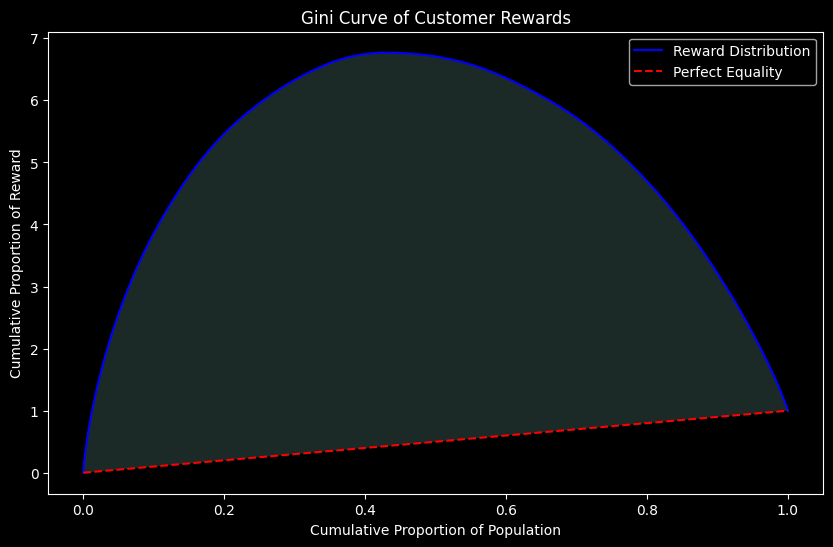

In [43]:
import numpy as np
import matplotlib.pyplot as plt


def gini_curve(y):
    # Sort values in ascending order
    sorted_y = np.sort(y)
    n = len(y)

    # Calculate cumulative proportion of population and values
    cum_population = np.arange(1, n + 1) / n
    cum_values = np.cumsum(sorted_y) / np.sum(sorted_y)

    # Add point (0,0) for complete curve
    cum_population = np.insert(cum_population, 0, 0)
    cum_values = np.insert(cum_values, 0, 0)

    return cum_population, cum_values


# Set style for dark theme
plt.style.use("dark_background")

# Calculate Gini curve
pop, val = gini_curve(uplift_data["reward"])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(pop, val, "b-", label="Reward Distribution")
plt.plot([0, 1], [0, 1], "r--", label="Perfect Equality")
plt.fill_between(pop, val, pop, alpha=0.2)
plt.xlabel("Cumulative Proportion of Population")
plt.ylabel("Cumulative Proportion of Reward")
plt.title("Gini Curve of Customer Rewards")
plt.legend()
plt.grid(False)
plt.show()

In [200]:
from typing import Optional

discount_assignment_prompt = """
You are a discount assignment agent. You are given a list of customers and their characteristic data. 
You are also given a dataframe containing the predicted reward of giving a discount to each customer.

The reward is calculated as the difference between the predicted uplift and the predicted discount value.

The marketing agent also has their own objective in addition to that of maximizing the reward.clear

Your goal is to select {n_customers} customers to give a discount to.

If you want to run a SQL query, return the query as a string in the following format:

```
{query}
```

"""

class DiscountAction(BaseModel):
    customer_ids: list[str]
    discount_level: float = Field(ge=0.0, le=1.0, description="The discount level to be applied to the customers")
    message: str = Field(description="A message to the customer")
    product_ids: list[str] = Field(description="The product ids to be discounted")  



class DiscountAssignmentTool(BaseModel):
    customers: list[CustomerState]
    effect_estimator: EffectEstimator
    uplift_data: Optional[pandas.DataFrame] = Field(init=False, default=None)

    class Config:
        arbitrary_types_allowed = True

    def assign_discount(self, discount: float) -> list[CustomerState]:
        uplift_data = self.effect_estimator.predict(
            pandas.DataFrame([x.model_dump() for x in self.customers])
        )
        uplift_data["new_aov"] = uplift_data["aov"] + uplift_data["effect"]
        uplift_data["new_discount"] = uplift_data["new_aov"] * discount
        uplift_data["reward"] = uplift_data["effect"] - uplift_data["new_discount"]
        self.uplift_data = uplift_data
        return uplift_data

    def get_best_customers(self, n: int) -> pandas.DataFrame:
        return self.uplift_data.sort_values("reward", ascending=False).head(n)

    def forward( self, prompt: str ) -> str:
